In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '../NSCL-PyTorch-Release/')

In [48]:
import torch
import torch.nn as nn
from torchvision.models import resnet
from torch.utils.data import DataLoader

import json
import math
import json
import pickle
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
img_size = 256

ans_dict_json = 'data/clevr/CLEVR_built_dictionaries.json'

image_root = 'data/clevr/train/images/'
vocab_json = 'data/clevr/train/vocab.json'
train_scenes_json = 'data/clevr/train/scenes.json'
train_questions_json = 'data/clevr/train/questions.json'

val_image_root = 'data/clevr/val/images/'
val_vocab_json = 'data/clevr/val/vocab.json'
val_scenes_json = 'data/clevr/val/scenes.json'
val_questions_json = 'data/clevr/val/questions.json'

dataset_args = {
    'train': {
        'scenes_json': train_scenes_json,
        'questions_json': train_questions_json,
        'image_root': image_root,
        'vocab_json': vocab_json,
    },
    'val': {
        'scenes_json': val_scenes_json,
        'questions_json': val_questions_json,
        'image_root': val_image_root,
        'vocab_json': val_vocab_json,
    },
}

image_transform = gen_image_transform(img_size)
bbox_transform = gen_bbox_transform(img_size)

In [5]:
split = 'train'

my_dataset = MyDataset(
    image_transform=image_transform,
    bbox_transform=bbox_transform,
    ans_dict_json=ans_dict_json,
    **dataset_args[split],
    sample_size=70000,
    seed=42,
)

Loading answers from: "data/clevr/CLEVR_built_dictionaries.json"
Loading scenes from: "data/clevr/train/scenes.json".
Loading questions from: "data/clevr/train/questions.json".
Loading vocab from: "data/clevr/train/vocab.json".
Preparing scenes
45583/45583
Preparing questions
70000/70000


## Train

In [34]:
with open('data/clevr/train/scenes.json', 'r') as f:
    train_scenes = json.load(f)

In [33]:
with open('../../../datasets/CLEVR_sample/questions/CLEVR_train_questions_sample.json', 'r') as f:
    sample_train_questions = json.load(f)

In [80]:
sample_train_questions.keys()

dict_keys(['answer', 'image_filename', 'image_index', 'program', 'question', 'question_family_index', 'question_index', 'split'])

In [83]:
sample_train_questions = [{key: sample_train_questions[key][idx] for key in sample_train_questions.keys()} for idx in sample_train_questions['question'].keys()]

In [100]:
sample_train_questions[0]

{'answer': 'rubber',
 'image_filename': 'CLEVR_train_000003.png',
 'image_index': 3,
 'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
  {'inputs': [0], 'function': 'filter_color', 'value_inputs': ['blue']},
  {'inputs': [1], 'function': 'unique', 'value_inputs': []},
  {'inputs': [2], 'function': 'relate', 'value_inputs': ['right']},
  {'inputs': [3], 'function': 'filter_size', 'value_inputs': ['small']},
  {'inputs': [4], 'function': 'filter_shape', 'value_inputs': ['cube']},
  {'inputs': [5], 'function': 'unique', 'value_inputs': []},
  {'inputs': [6], 'function': 'query_material', 'value_inputs': []}],
 'question': 'What material is the tiny cube that is to the right of the blue thing?',
 'question_family_index': 76,
 'question_index': 30,
 'split': 'train'}

In [119]:
sample_train_scenes = dict([(s['image_index'], s) for s in train_scenes] )

TypeError: string indices must be integers

In [101]:
with open('data/clevr_sample_preprocessed/train/questions.json', 'w') as f:
    json.dump(sample_train_questions, f)

In [102]:
with open('data/clevr_sample_preprocessed/train/questions.pkl', 'wb') as f:
    pickle.dump(sample_train_questions, f)

In [103]:
with open('data/clevr_sample_preprocessed/train/scenes.json', 'w') as f:
    json.dump(sample_train_scenes, f)

In [105]:
with open('data/clevr_sample_preprocessed/train/scenes.pkl', 'wb') as f:
    pickle.dump(sample_train_scenes, f)

In [84]:
sample_train_questions[0]

{'answer': 'rubber',
 'image_filename': 'CLEVR_train_000003.png',
 'image_index': 3,
 'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
  {'inputs': [0], 'function': 'filter_color', 'value_inputs': ['blue']},
  {'inputs': [1], 'function': 'unique', 'value_inputs': []},
  {'inputs': [2], 'function': 'relate', 'value_inputs': ['right']},
  {'inputs': [3], 'function': 'filter_size', 'value_inputs': ['small']},
  {'inputs': [4], 'function': 'filter_shape', 'value_inputs': ['cube']},
  {'inputs': [5], 'function': 'unique', 'value_inputs': []},
  {'inputs': [6], 'function': 'query_material', 'value_inputs': []}],
 'question': 'What material is the tiny cube that is to the right of the blue thing?',
 'question_family_index': 76,
 'question_index': 30,
 'split': 'train'}

In [89]:
sample_train_sizes = [len(s['objects']) for s in tqdm(sample_scenes.values())]

In [90]:
uniques, counts = np.unique(list(sample_train_sizes), return_counts=True)

(array([856., 857., 895., 860., 854., 875., 882., 921.]),
 array([ 3.   ,  3.875,  4.75 ,  5.625,  6.5  ,  7.375,  8.25 ,  9.125,
        10.   ]),
 <a list of 8 Patch objects>)

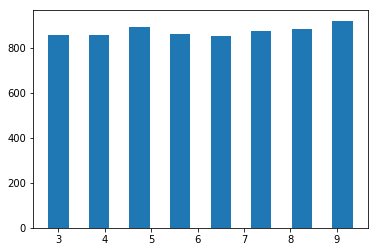

In [99]:
plt.hist(sample_sizes, bins=8, align='left', rwidth=0.5)

## Val

In [108]:
with open('data/clevr/val/scenes.json', 'r') as f:
    val_scenes = json.load(f)

In [109]:
with open('../../../datasets/CLEVR_sample/questions/CLEVR_val_questions_sample.json', 'r') as f:
    sample_val_questions = json.load(f)

In [110]:
sample_val_questions = [{key: sample_val_questions[key][idx] for key in sample_val_questions.keys()} for idx in sample_val_questions['question'].keys()]

In [111]:
sample_val_questions[0]

{'answer': 'no',
 'image_filename': 'CLEVR_val_000009.png',
 'image_index': 9,
 'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
  {'inputs': [0], 'function': 'filter_size', 'value_inputs': ['large']},
  {'inputs': [1], 'function': 'filter_color', 'value_inputs': ['brown']},
  {'inputs': [2], 'function': 'unique', 'value_inputs': []},
  {'inputs': [3], 'function': 'same_shape', 'value_inputs': []},
  {'inputs': [4], 'function': 'exist', 'value_inputs': []}],
 'question': 'Are there any other things that are the same shape as the big brown object?',
 'question_family_index': 39,
 'question_index': 90,
 'split': 'val'}

In [113]:
sample_val_scenes_idxs = [q['image_index'] for q in sample_val_questions]

In [114]:
sample_val_scenes = np.array(val_scenes['scenes'])[sample_val_scenes_idxs]

In [116]:
sample_val_scenes = dict([(s['image_index'], s) for s in sample_val_scenes] )

In [117]:
sample_val_scenes

{9: {'image_index': 9,
  'objects': [{'color': 'gray',
    'size': 'large',
    'rotation': 25.197049031482717,
    'shape': 'cube',
    '3d_coords': [0.4531235992908478, -1.7338027954101562, 0.699999988079071],
    'material': 'rubber',
    'pixel_coords': [185, 163, 9.987650871276855]},
   {'color': 'brown',
    'size': 'small',
    'rotation': 124.23168902181999,
    'shape': 'sphere',
    '3d_coords': [-1.176740288734436, 1.6663388013839722, 0.3499999940395355],
    'material': 'metal',
    'pixel_coords': [261, 111, 13.180752754211426]},
   {'color': 'blue',
    'size': 'large',
    'rotation': 31.996501006495592,
    'shape': 'cube',
    '3d_coords': [-0.00787865836173296, 2.3643031120300293, 0.699999988079071],
    'material': 'rubber',
    'pixel_coords': [316, 105, 12.613685607910156]},
   {'color': 'brown',
    'size': 'large',
    'rotation': 9.719135820192415,
    'shape': 'cylinder',
    '3d_coords': [-2.332704544067383, -1.0313242673873901, 0.699999988079071],
    'materi

In [120]:
with open('data/clevr_sample/val/questions.json', 'w') as f:
    json.dump(sample_val_questions, f)

with open('data/clevr_sample/val/questions.pkl', 'wb') as f:
    pickle.dump(sample_val_questions, f)

with open('data/clevr_sample/val/scenes.json', 'w') as f:
    json.dump(sample_val_scenes, f)

with open('data/clevr_sample/val/scenes.pkl', 'wb') as f:
    pickle.dump(sample_val_scenes, f)

In [121]:
sample_val_sizes = [len(s['objects']) for s in tqdm(sample_val_scenes.values())]

In [122]:
uniques, counts = np.unique(list(sample_val_sizes), return_counts=True)

(array([207., 179., 184., 165., 167., 204., 181., 213.]),
 array([ 3.   ,  3.875,  4.75 ,  5.625,  6.5  ,  7.375,  8.25 ,  9.125,
        10.   ]),
 <a list of 8 Patch objects>)

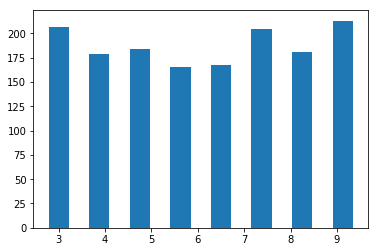

In [123]:
plt.hist(sample_val_sizes, bins=8, align='left', rwidth=0.5)